# Sudodle simulations


In [2]:
%load_ext autoreload
%autoreload 2

In [4]:
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from concurrent.futures import ProcessPoolExecutor, as_completed
from sudodle_simulation import (
    simulate_game,
    cyclic_latin_square,
    uniform_random_latin_square,
    square_to_string,
    run_multiple_simulations_in_parallel,
)

from sudodle_plotting import plot_simulation_histogram


## Results starting from the classic cyclic latin square


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

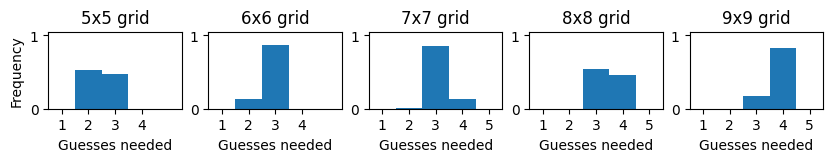

In [8]:
fig, axes = plt.subplots(1, 5, figsize=(10, 1))
for i, ax in enumerate(axes):
    n = i + 5
    cyclic_square = cyclic_latin_square(n)
    tries_list = run_multiple_simulations_in_parallel(10_000 * [cyclic_square])
    n_tries_list = [len(tries) + 1 for tries in tries_list if tries is not None]
    plot_simulation_histogram(n_tries_list, ax=ax, title=f"{n}x{n} grid")
    if ax != axes[0]:
        ax.set_ylabel("")
fig.savefig("outputs/simulation_5_to_9.jpeg", bbox_inches="tight")

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

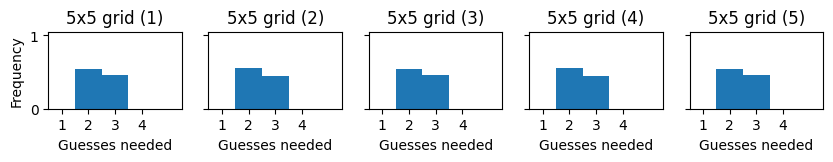

In [12]:
fig, axes = plt.subplots(1, 5, figsize=(10, 1))
for i, ax in enumerate(axes):
    first_guess = uniform_random_latin_square(5)
    tries_list = run_multiple_simulations_in_parallel(10_000 * [first_guess])
    n_tries_list = [len(tries) + 1 for tries in tries_list if tries is not None]
    plot_simulation_histogram(n_tries_list, ax=ax, title=f"5x5 grid ({i + 1})")
    if ax != axes[0]:
        ax.set_ylabel("")
        ax.set_yticklabels([])
fig.savefig("outputs/simulations_random_latin_squares.jpeg", bbox_inches="tight")


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

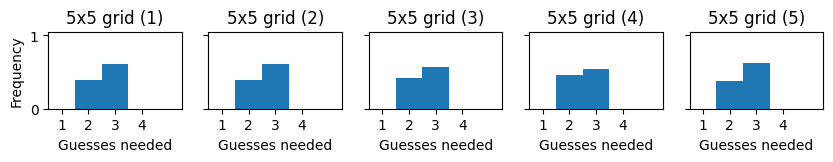

In [18]:
from sudodle_simulation import random_square

fig, axes = plt.subplots(1, 5, figsize=(10, 1))
first_guesses = [random_square(5) for _ in range(5)]
for i, (ax, first_guess) in enumerate(zip(axes, first_guesses)):
    tries_list = run_multiple_simulations_in_parallel(10_000 * [first_guess])
    n_tries_list = [len(tries) + 1 for tries in tries_list if tries is not None]
    plot_simulation_histogram(n_tries_list, ax=ax, title=f"5x5 grid ({i + 1})")
    if ax != axes[0]:
        ax.set_ylabel("")
        ax.set_yticklabels([])
fig.savefig("outputs/simulations_random_squares.jpeg", bbox_inches="tight")

In [15]:
tries_list[:10]

[[0, 3, 8],
 [0, 7],
 [0, 8],
 [0, 5],
 [0, 4, 13],
 [0, 1, 4],
 [0, 6],
 [0, 5, 11],
 [0, 3, 8],
 [0, 10]]

In [19]:
selected = [result for result in tries_list if len(result) == 2 and result[1] < 4]
len(selected)

166

| 1 1 1 1 1
| 2 2 2 2 2
| 3 3 3 3 3
| 4 4 4 4 4
| 5 5 5 5 5


Running simulations:   0%|          | 0/10000 [00:00<?, ?it/s]

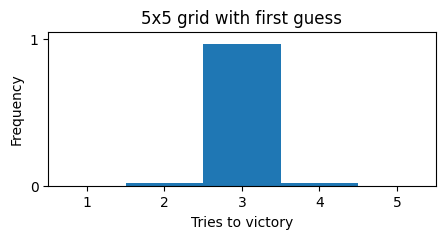

In [30]:
n = 5
first_guess = [n * [i + 1] for i in range(n)]
print(square_to_string(first_guess))
fig, ax = plt.subplots(1, 1, figsize=(5, 2))
simulation_histogram(
    first_guess, ax, title="5x5 grid with first guess", sample_size=10_000
)

In [151]:
from sudodle_plotting import plot_puzzles_pdf_from_txt

for i in 4, 5, 6:
    plot_puzzles_pdf_from_txt(f"rust_puzzle_finder/outputs/s{i}.txt", i)

Successfully parsed 26 puzzles from rust_puzzle_finder/outputs/s4.txt
Successfully parsed 1560 puzzles from rust_puzzle_finder/outputs/s5.txt
Successfully parsed 57 puzzles from rust_puzzle_finder/outputs/s6.txt


In [152]:
plot_puzzles_pdf_from_txt(f"rust_puzzle_finder/outputs/s7-p10-1M.txt", 7)


Successfully parsed 18 puzzles from rust_puzzle_finder/outputs/s7-p10-1M.txt


In [51]:
from sudodle_simulation import find_single_solution_puzzles, cyclic_latin_square

square = cyclic_latin_square(5)
solutions = find_single_solution_puzzles(grid, n_well_placed=2)
len(solutions)


0it [00:00, ?it/s]

26

In [24]:
solutions = find_single_solution_puzzles(N=6, n_well_placed=5)
len(solutions)

TypeError: find_single_solution_puzzles() got an unexpected keyword argument 'N'

In [ ]:
uniquified_selected_solutions = set()
for correct_tiles, solution in selected_solutions:
    uniquified_selected_solutions.add(standardize_puzzle(correct_tiles))
len(uniquified_selected_solutions)

2892

### Process the mined puzzles


In [ ]:
from sudodle_simulation import parse_puzzles_from_txt
from pathlib import Path

N = 5
folder = Path("rust_puzzle_finder/outputs")
file_name = "s5.txt"


def process(file_name, N):
    puzzles = parse_puzzles_from_txt(
        "rust_puzzle_finder/outputs/s5.txt", N, standardize_tiles=False
    )
    compact_puzzles = [[N * i + j for (i, j) in tiles] for tiles in puzzles]
    as_csv = "\n".join([",".join([f"{n}" for n in tiles]) for tiles in compact_puzzles])
    (folder / file_name.replace(".txt", "_compact.csv")).write_text(as_csv)


for file_name, N in [
    ("s4.txt", 4),
    ("s5.txt", 5),
    ("s6.txt", 6),
    ("s7-p10-10M.txt", 7),
]:
    process(file_name, N)


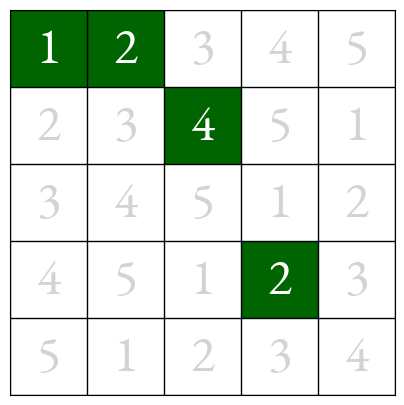

In [109]:
import matplotlib.pyplot as plt
from sudodle_simulation import cyclic_latin_square, plot_puzzle


def plot_puzzle(N, well_placed_tiles):
    """Plot the cyclic latin square with Matplotlib and highlight
    the well placed tiles in green."""
    grid = cyclic_latin_square(N)
    fig, ax = plt.subplots(figsize=(N, N))
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlim(0, N)
    ax.set_ylim(0, N)
    ax.set_aspect("equal")
    ax.grid(True, linestyle="--", linewidth=0.5, color="gray")
    tile_coordinates = [(i, j) for i in range(N) for j in range(N)]
    # Draw grid lines
    for i in range(N + 1):
        ax.axhline(y=i, color="black", linewidth=1)
        ax.axvline(x=i, color="black", linewidth=1)
    for i, j in tile_coordinates:
        if (i, j) in well_placed_tiles:
            color = "white"
            ax.add_patch(plt.Rectangle((j, N - i - 1), 1, 1, facecolor="darkgreen"))
        else:
            color = "lightgrey"
        ax.text(
            x=j + 0.5,
            y=N - i - 0.55,
            s=grid[i][j],
            ha="center",
            va="center",
            fontsize=36,
            fontfamily="EB Garamond",
            color=color,
        )


plot_puzzle(5, selected_solutions[10][0])


In [61]:
selected_solutions[0]


[[1, 2, 4, 5, 3],
 [2, 4, 3, 1, 5],
 [4, 3, 5, 2, 1],
 [5, 1, 2, 3, 4],
 [3, 5, 1, 4, 2]]

In [28]:
from ortools_solver import random_latin_square_with_ortools

square = random_latin_square_with_ortools(5, seed=42)
square

[[3, 4, 5, 2, 1],
 [4, 5, 2, 1, 3],
 [5, 1, 4, 3, 2],
 [2, 3, 1, 5, 4],
 [1, 2, 3, 4, 5]]

In [35]:
%%timeit
a = random_latin_square_with_ortools(9, seed=42)

19.5 ms ± 72.8 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [30]:
from sudodle_simulation import backtracked_random_latin_square


In [34]:
%%timeit
a = backtracked_random_latin_square(9, seed=42)

80.6 μs ± 347 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [ ]:
from sudo